# Thematic differences (Hungary)

DHH23 Parliament group

Author: Pontus H.

In [103]:
# Set the theme here
THEME = 'war_HU'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'
# Set the output path for the model
MODEL_PATH = '../data/models/'

In [104]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [105]:
# Hungarian stopwords
with open('../data/stopwords-hu.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [106]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 20 # This was lowered from 50 to 10 for gender_HU
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [107]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,u2017-11-27-183,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-11-27,Unicameralism,7,NaN,89,1,NaN,Reference,...,Fidesz-frakció,A Fidesz – Magyar Polgári Szövetség parlamenti...,Coalition,"Németh, Zsolt",M,1963.0,Tisztelt Ház! Tisztelt Miniszter Úr! Szeptembe...,Október hónapban a Magyar Országgyűlésben kia...,0.548828,1552
1,u2017-12-12-69,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-12-12,Unicameralism,7,NaN,90,2,NaN,Reference,...,Fidesz-frakció,A Fidesz – Magyar Polgári Szövetség parlamenti...,Coalition,"Hörcsik, Richárd",M,1955.0,Köszönöm a szót. Tisztelt Elnök Úr! Tisztelt Á...,Tisztelt Elnök Úr! Tisztelt Államtitkár Úr! T...,0.466309,10455
2,u2017-03-06-175,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-03-06,Unicameralism,7,NaN,74,1,NaN,Reference,...,Fidesz-frakció,A Fidesz – Magyar Polgári Szövetség parlamenti...,Coalition,"Gelencsér, Attila",M,1968.0,"Köszönöm a szót, elnök úr. Tisztelt Államtitká...",Tisztelt Államtitkár Úr! Hosszú ideje már ann...,-0.120667,2007
3,u2017-03-06-301,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-03-06,Unicameralism,7,NaN,74,1,NaN,Reference,...,MSZP-frakció,A Magyar Szocialista Párt parlamenti frakciója,Opposition,"Harangozó, Gábor István",M,1975.0,"Köszönöm, elnök úr. A Magyar Zoltán képviselőt...",A Magyar Zoltán képviselőtársam által elmondo...,-0.585449,4576
4,u2017-02-20-5,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-02-20,Unicameralism,7,NaN,73,1,NaN,Reference,...,MSZP-frakció,A Magyar Szocialista Párt parlamenti frakciója,Opposition,"Tóth, Bertalan",M,1975.0,"Köszönöm a szót, elnök úr. Tisztelt Képviselőt...",Tisztelt Képviselőtársaim! Miniszterelnök Úr!...,-0.931641,6881


In [108]:
df['Speaker_party'].describe()

count                794
unique                17
top       Fidesz-frakció
freq                 229
Name: Speaker_party, dtype: object

In [109]:
# Reference running time for this cell: 4min 00s
topics, probs = topic_model.fit_transform(df['speech'])


In [110]:
# Reduce outliers
# threshold was decreased from 0.1 to 0.05 for gender_HU
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=0.05)


In [111]:
pd.Series(new_topics).value_counts()

 0    337
 2    136
 1    113
 3    102
 4     51
 5     51
 6     27
-1      3
dtype: int64

In [112]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [113]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [114]:
# Number of topics
print(f"Number of topics: {len(pd.Series(new_topics).unique())}")

Number of topics: 8


In [115]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

 0    236
-1    209
 2    100
 5     99
 6     60
 3     51
 1     44
 4     21
dtype: int64

In [116]:
topic_model.visualize_topics()

Topics over time

In [117]:
# Reference running time for this cell: 2min 30s

# topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [118]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [119]:
# topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [120]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
# Create the output directory if it does not exist
import os
if not os.path.exists(f"{OUTPUT_PATH}{THEME}"):
    os.makedirs(f"{OUTPUT_PATH}{THEME}")
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}/{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

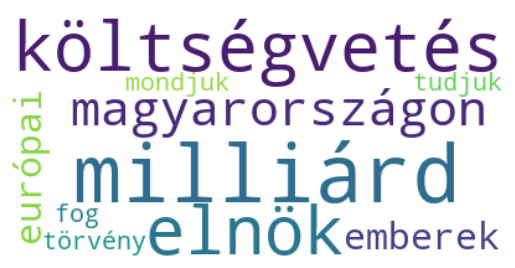

In [121]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [122]:
# topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [123]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
# get_keywords(0)

In [124]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'Fidesz-KDNP' if the name contains Fidesz-frakció,  KNDP-frakció or Fidesz
speech_topic_party.loc[speech_topic_party['party'].str.contains('Fidesz-frakció|KNDP-frakció|Fidesz'), 'party'] = 'Fidesz-KDNP'
# Set the party name to 'Opposition' if the name contains MSZP or MSZP-frakció
speech_topic_party.loc[speech_topic_party['party'].str.contains('MSZP|MSZP-frakció'), 'party'] = 'Opposition'
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-KDNP' or 'Opposition'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('Fidesz-KDNP|Opposition'), 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
#speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,106,169,51
1,72,30,7
2,78,45,8
3,63,26,9
4,10,31,9
5,23,20,7
6,12,11,4


In [125]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,29.1,50.9,53.7
1,19.8,9.0,7.4
2,21.4,13.6,8.4
3,17.3,7.8,9.5
4,2.7,9.3,9.5
5,6.3,6.0,7.4
6,3.3,3.3,4.2


In [126]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
# percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,Fidesz-KDNP,OTHER,Opposition,keywords
topic,,,,
0,29.1,50.9,53.7,"[milliárd, költségvetés, elnök, magyarországon..."
1,19.8,9.0,7.4,"[tisztelt, ház, elnök, magyarország, taps, kor..."
2,21.4,13.6,8.4,"[nemzetközi, gazdasági, illegális, magyarorszá..."
3,17.3,7.8,9.5,"[magyarország, háború, tisztelt, orosz, európa..."
4,2.7,9.3,9.5,"[fidesz, civil, kínai, magyarország, viktor, g..."
5,6.3,6.0,7.4,"[iraki, tisztelt, nemzetiségi, iszlám, magyaro..."
6,3.3,3.3,4.2,"[bence, dr, magyar, elnök, 2010, infláció, kem..."


In [127]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
# percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,Fidesz-KDNP,OTHER,Opposition
0,0,32.5,51.8,15.6
1,1,66.1,27.5,6.4
2,2,59.5,34.4,6.1
3,3,64.3,26.5,9.2
4,4,20.0,62.0,18.0
5,5,46.0,40.0,14.0
6,6,44.4,40.7,14.8


Calculate mean sentiment for each topic per party

In [128]:
# sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'speech_id': df['ID'], 'party': df['Speaker_party'], 'sentiment': df['sentiment'], 'speech_date': df['Date'], 'prob': list(probs), 'speech': df['speech']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'Fidesz-KDNP' if the name contains Fidesz-frakció,  KNDP-frakció or Fidesz
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('Fidesz-frakció|KNDP-frakció|Fidesz'), 'party'] = 'Fidesz-KDNP'
# Set the party name to 'Opposition' if the name contains MSZP or MSZP-frakció
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('MSZP|MSZP-frakció'), 'party'] = 'Opposition'
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-KDNP' or 'Opposition'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('Fidesz-KDNP|Opposition'), 'party'] = 'OTHER'
# Create a new dataframe with the relevant speeches and remove
relevant_speeches = sentiment_topic_party.copy()
sentiment_topic_party.drop(columns=['speech', 'speech_date', 'prob'], inplace=True)
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
# sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,-0.26,-0.56,-0.54
1,0.25,-0.09,-0.08
2,-0.01,-0.42,-0.17
3,-0.41,-0.53,-0.45
4,-0.73,-0.71,-0.65
5,0.08,-0.04,0.03
6,-0.51,-0.86,-0.85


In [129]:
# Save the topic model
topic_model.save(f"{MODEL_PATH}{THEME}_topic_model.bin")

In [130]:
def get_top_3(topic_id, party_name):
    speeches_for_topic_0_con = relevant_speeches[(relevant_speeches['party'] == party_name) & (relevant_speeches['topic'] == topic_id)]
    speeches_for_topic_0_con['prob'] = speeches_for_topic_0_con['prob'].apply(lambda x: x[topic_id])
    speeches_for_topic_0_con = speeches_for_topic_0_con.sort_values(by='sentiment', ascending=False)
    most_positive = speeches_for_topic_0_con.head(3)
    most_negative = speeches_for_topic_0_con.tail(3)
    return most_positive.append(most_negative).drop_duplicates(subset=['speech_id'])

parties = ['Fidesz-KDNP', 'Opposition', 'OTHER']

max_topic = relevant_speeches['topic'].max()

representative_speeches = get_top_3(0, 'Fidesz-KDNP')
for party in parties[1:]:
    representative_speeches = representative_speeches.append(get_top_3(0, party))
for topic_id in range(1,max_topic+1):
    for party in parties:
        representative_speeches = representative_speeches.append(get_top_3(topic_id, party))

# Save the representative speeches to a csv and feather file. Use '"" as the quotechar to avoid issues with the speech text
representative_speeches.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.csv', quotechar='"', index=False)
representative_speeches.reset_index().to_feather(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.feather')
representative_speeches

,topic,speech_id,party,sentiment,speech_date,prob,speech
802,0,u2019-07-02-21,Fidesz-KDNP,0.702637,2019-07-02,0.175419,Köszönöm szépen. Tisztelt Elnök Úr! Tisztelt O...
812,0,u2019-10-21-21,Fidesz-KDNP,0.683594,2019-10-21,0.266895,"Szeretnék. Köszönöm szépen, elnök úr. Csak azt..."
118,0,u2022-05-24-31,Fidesz-KDNP,0.663086,2022-05-24,0.036451,Köszönöm szépen. Tisztelt Elnök Úr! Tisztelt K...
136,0,u2022-05-17-67,Fidesz-KDNP,-0.970215,2022-05-17,0.997530,Köszönöm szépen a szót. Tisztelt Elnök Úr! Meg...
61,0,u2021-04-12-221,Fidesz-KDNP,-0.986328,2021-04-12,0.125424,"Köszönöm, elnök úr. Most már több mint egy éve..."
...,...,...,...,...,...,...,...
501,6,u2020-12-01-17,OTHER,-0.595703,2020-12-01,0.994620,Köszönöm a szót. Tisztelt Elnök Úr! Tisztelt H...
96,6,u2021-12-06-39,OTHER,-0.841309,2021-12-06,0.992621,"Köszönöm szépen, elnök úr, a szót. Ma úgy láts..."
255,6,u2022-03-10-1-242,OTHER,-0.984863,2022-03-10,0.995609,"Köszönöm a szót, elnök úr, bár nem tudom, ki f..."
17,6,u2017-06-12-7,OTHER,-0.998047,2017-06-12,0.995374,"Köszönöm a szót, elnök úr. Tisztelt Minisztere..."


In [131]:
# Create a new dataframe from percentages, percentages_per_row and sentiment_topic_party
concatenated_results = pd.concat([percentages, percentages_per_row, sentiment_topic_party], axis=1)
# Rename the columns to make it easier to understand
concatenated_results.columns = ['pf.Fidesz-KDNP', 'pf.OTHER', 'pf.Opposition', 'keywords', 'tc.Fidesz-KDNP', 'tc.OTHER', 'tc.Opposition', 's.Fidesz-KDNP', 's.OTHER', 's.Opposition']
# Reorder the columns
concatenated_results = concatenated_results[['keywords', 'tc.Fidesz-KDNP', 'tc.Opposition', 'tc.OTHER', 'pf.Fidesz-KDNP', 'pf.Opposition', 'pf.OTHER', 's.Fidesz-KDNP', 's.Opposition', 's.OTHER']]
# Save the results to a csv
concatenated_results.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_results.csv')
concatenated_results

,keywords,tc.Fidesz-KDNP,tc.Opposition,tc.OTHER,pf.Fidesz-KDNP,pf.Opposition,pf.OTHER,s.Fidesz-KDNP,s.Opposition,s.OTHER
topic,,,,,,,,,,
0,"[milliárd, költségvetés, elnök, magyarországon...",32.5,15.6,51.8,29.1,53.7,50.9,-0.26,-0.54,-0.56
1,"[tisztelt, ház, elnök, magyarország, taps, kor...",66.1,6.4,27.5,19.8,7.4,9.0,0.25,-0.08,-0.09
2,"[nemzetközi, gazdasági, illegális, magyarorszá...",59.5,6.1,34.4,21.4,8.4,13.6,-0.01,-0.17,-0.42
3,"[magyarország, háború, tisztelt, orosz, európa...",64.3,9.2,26.5,17.3,9.5,7.8,-0.41,-0.45,-0.53
4,"[fidesz, civil, kínai, magyarország, viktor, g...",20.0,18.0,62.0,2.7,9.5,9.3,-0.73,-0.65,-0.71
5,"[iraki, tisztelt, nemzetiségi, iszlám, magyaro...",46.0,14.0,40.0,6.3,7.4,6.0,0.08,0.03,-0.04
6,"[bence, dr, magyar, elnök, 2010, infláció, kem...",44.4,14.8,40.7,3.3,4.2,3.3,-0.51,-0.85,-0.86
